### GPS Tracking demo for MS-Dessi

Let's collect gps sensor data in one data 
frame

In [2]:
import pandas as pd
from datetime import datetime

In [5]:


lat_file = pd.read_csv("ms-dessi-data/data_latitude_016b.csv")
long_file = pd.read_csv("ms-dessi-data/data_longitude_016b.csv")
df = pd.merge(lat_file, long_file, on="time")
df = df.rename(columns={"latitude_016b": "latitude", "longitude_016b": "longitude"})
df  = df.drop(['mean_x', 'mean_y'], axis=1)
df['date'] = pd.to_datetime(df['time'], format='mixed').dt.date
print(df.head())
print('\nNum non-None Longitude records: ' + str(len(df[~pd.isnull(df.longitude)])))
print('\nNum of unique dates: ' + str( len(df.date.unique())))
df_15sept = df[df.date == datetime.strptime("2023-09-15", '%Y-%m-%d').date()]
print('\nNum of records on the 15th of september: ' + str(len(df[df.date == datetime.strptime("2023-09-15", '%Y-%m-%d').date()])))

                               time   latitude  longitude        date
0  2023-10-12 15:55:19.121000+00:00  56.110627  15.589967  2023-10-12
1  2023-10-12 15:50:33.625000+00:00  56.127631  15.592885  2023-10-12
2  2023-10-12 14:53:31.496000+00:00  56.127631  15.592885  2023-10-12
3  2023-10-12 14:41:18.594000+00:00  56.127631  15.592885  2023-10-12
4  2023-10-12 14:33:00.061000+00:00  56.108545  15.590460  2023-10-12

Num non-None Longitude records: 281

Num of unique dates: 42

Num of records on the 15th of september: 38


Visualising all available points on the map 

In [6]:
%matplotlib inline

In [7]:
import folium   # (https://pypi.python.org/pypi/folium)
df = df_15sept
mymap = folium.Map( location=[ df.latitude.mean(), df.longitude.mean() ], zoom_start=14)
#folium.PolyLine(df[['Latitude','Longitude']].values, color="red", weight=2.5, opacity=1).add_to(mymap)
for coord in df[['latitude','longitude']].values:
    folium.CircleMarker(location=[coord[0],coord[1]], radius=1,color='red').add_to(mymap)
mymap

# Weather Station Data


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# read data
df1 = pd.read_csv('ms-dessi-data/data_temperature_cafe.csv')
df2 = pd.read_csv('ms-dessi-data/data_temperature_48b3.csv')
df1.head()
df2.head()

,time,temperature_48b3,mean
0,2023-10-13 08:48:19.615000+00:00,10.5,10.5
1,2023-10-13 08:38:19.768000+00:00,10.0,10.0
2,2023-10-13 08:28:19.628000+00:00,10.3,10.3
3,2023-10-13 08:18:19.792000+00:00,10.3,10.3
4,2023-10-13 08:08:19.814000+00:00,10.1,10.1


In [10]:
# convert your date column to datetime if it's not
df1['time'] = pd.to_datetime(df1['time'], format='mixed')
df2['time'] = pd.to_datetime(df2['time'], format='mixed')


In [11]:
# set date column as index if it's not
df1 = df1.set_index('time')
df2 = df2.set_index('time')


In [12]:
print("Dataframe shape: ", df1.shape)
dt = (df1.index[-1] - df1.index[0])
print("Number of hours between start and end dates: ", dt.total_seconds()/3600 + 1)

Dataframe shape:  (2677, 2)
Number of hours between start and end dates:  -2732.871171388889


In [13]:
df1.index[0]

Timestamp('2023-10-13 07:53:38.281000+0000', tz='UTC')

In [14]:
df1.index[-1]

Timestamp('2023-06-21 10:01:22.064000+0000', tz='UTC')

# Raw temperature data

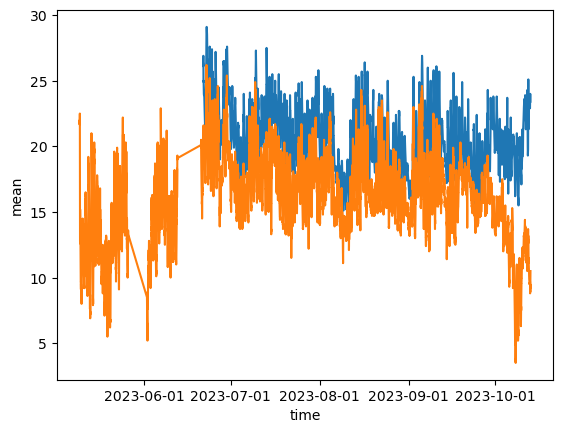

In [15]:
import matplotlib.dates
import seaborn as sns

ax = plt.subplot()

sns.lineplot(x="time", y="mean", data=df1)
sns.lineplot(x="time", y="mean", data=df2)

ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter("%Y-%m-%d")
)

plt.show()

# Smoothed (over a day) temperature data inside and outside

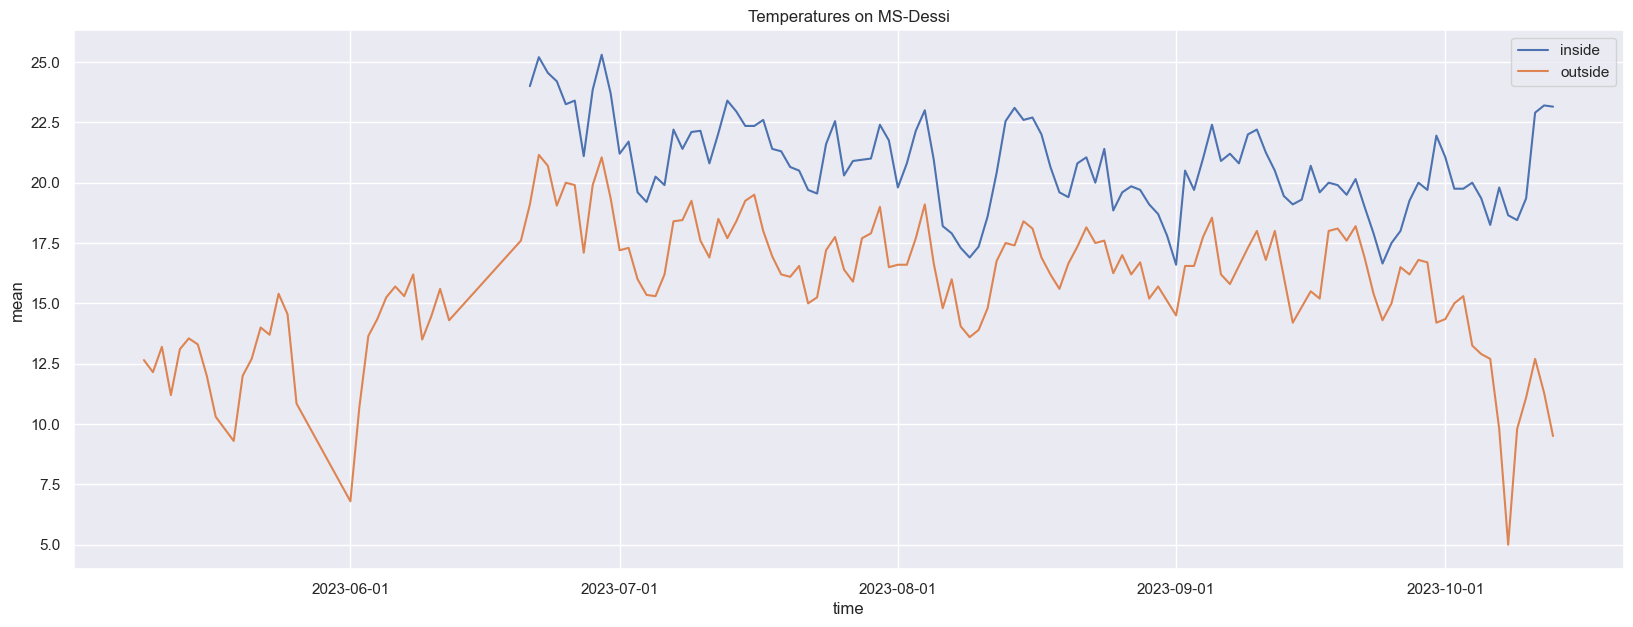

In [16]:
sns.set_theme(style="darkgrid")
plt.figure (figsize = (20, 7))
ax = plt.subplot()

sns.lineplot(x="time", y="mean", data=df1[["mean"]].resample("1d").median(), label="inside")
sns.lineplot(x="time", y="mean", data=df2[["mean"]].resample("1d").median(), label="outside")

ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter("%Y-%m-%d")
)
ax.set_title("Temperatures on MS-Dessi")
ax.legend()
plt.show()

In [4]:
df1 = pd.read_csv('ms-dessi-data/backup/data_temperature_cafe.csv')
df3 = pd.read_csv('ms-dessi-data/backup/data_relativeHumidity_cafe.csv')
df3['time'] = pd.to_datetime(df3['time'], format='mixed')
df1['time'] = pd.to_datetime(df1['time'], format='mixed')
df3.head()
#df3 = df3.set_index('time')


,time,relativeHumidity_bcff,mean
0,2023-10-13 07:53:38.281000+00:00,45,45
1,2023-10-13 06:53:39.224000+00:00,40,40
2,2023-10-13 05:53:39.417000+00:00,45,45
3,2023-10-13 04:54:29.337000+00:00,40,40
4,2023-10-13 03:53:39.965000+00:00,40,40


In [13]:
avg_daily_temp = pd.DataFrame(df1.groupby([df1["time"].dt.day])["mean"].mean())
avg_daily_temp["Temperature (C)"] = avg_daily_temp["mean"]
avg_daily_temp.reset_index(inplace=True)

avg_daily_humid = pd.DataFrame(df3.groupby([df3["time"].dt.day])["mean"].mean())
avg_daily_humid["Humidity (perc)"] = avg_daily_humid["mean"]
avg_daily_humid.reset_index(inplace=True)

avg_daily = pd.merge(avg_daily_temp, avg_daily_humid, on="time")
avg_daily[["Humidity (perc)","Temperature (C)"]].corr(method ='pearson')


,Humidity (perc),Temperature (C)
Humidity (perc),1.000000,-0.249597
Temperature (C),-0.249597,1.000000


## Temperature vs humidity iside

It seems like temperature and humidity are negatively correlated, but there is still a lot of variation in humidity despite temperature inside being relatively stable. 

<Figure size 2000x700 with 0 Axes>

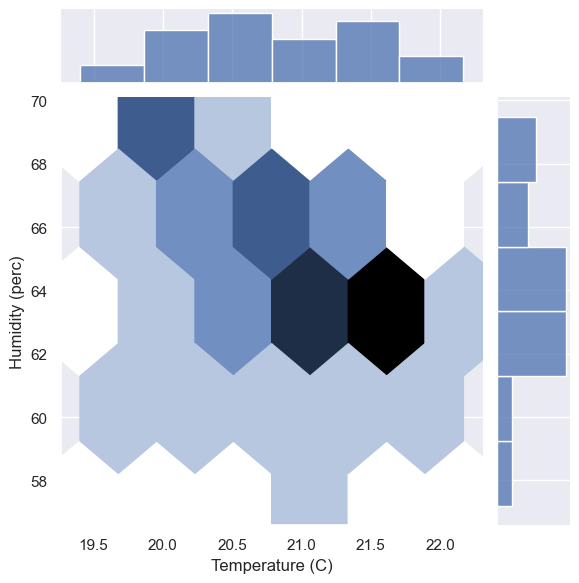

In [19]:
sns.set_theme(style="darkgrid")
plt.figure (figsize = (20, 7))

sns.jointplot(x='Temperature (C)',y='Humidity (perc)',data=avg_daily, kind='hex')
ax.set_title("Climate inside MS-Dessi")
ax.legend()
plt.show()

In [21]:
df4 = pd.read_csv('ms-dessi-data/backup/data_noiseLevelAverage_cafe.csv')
df4['time'] = pd.to_datetime(df4['time'], format='mixed')
df4.head()


,time,noiseLevelAverage_3b25,mean
0,2023-09-21 13:25:45.731000+00:00,62,62
1,2023-09-21 13:15:45.901000+00:00,55,55
2,2023-09-21 04:15:47.589000+00:00,62,62
3,2023-09-21 04:05:47.778000+00:00,56,56
4,2023-09-21 03:25:47.876000+00:00,34,34


In [15]:
avg_daily_loud = pd.DataFrame(df4.groupby([df4["time"].dt.day])["mean"].mean())
avg_daily_loud["Noise (db)"] = avg_daily_loud["mean"]
avg_daily_loud.reset_index(inplace=True)

avg_daily_all = pd.merge(avg_daily, avg_daily_loud, on="time")
avg_daily_all[["Humidity (perc)","Temperature (C)", "Noise (db)"]].corr(method ='pearson')
avg_daily_all.head()

,time,mean_x,Temperature (C),mean_y,Humidity (perc),mean,Noise (db)
0,1,19.914737,19.914737,67.800000,67.800000,44.789634,44.789634
1,2,20.664894,20.664894,66.223404,66.223404,43.500000,43.500000
2,3,20.474444,20.474444,65.366667,65.366667,44.586634,44.586634
3,4,20.654737,20.654737,61.431579,61.431579,45.783455,45.783455
4,5,20.982105,20.982105,57.200000,57.200000,45.976378,45.976378


In [16]:
# set date column as index if it's not
df3 = df3.set_index('time')
df4 = df4.set_index('time')

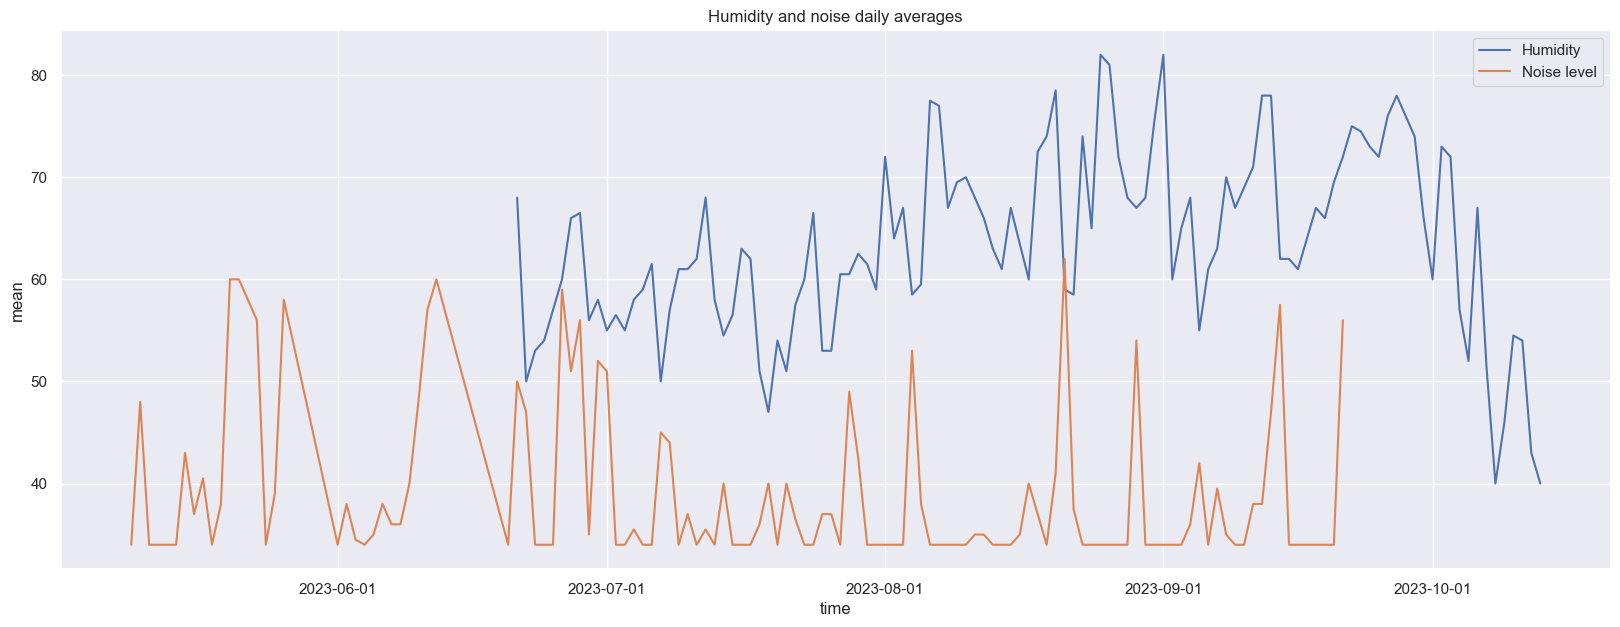

In [23]:


sns.set_theme(style="darkgrid")
plt.figure (figsize = (20, 7))
ax = plt.subplot()

sns.lineplot(x="time", y="mean", data=df3[["mean"]].resample("1d").median(), label="Humidity")
sns.lineplot(x="time", y="mean", data=df4[["mean"]].resample("1d").median(), label="Noise level")

ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter("%Y-%m-%d")
)
ax.set_title("Humidity and noise daily averages")
ax.legend()
plt.show()

In [20]:
df5 = pd.read_csv('ms-dessi-data/backup/data_all_3b25.csv')
df5['time'] = pd.to_datetime(df5['time'], format='mixed')
df5.head()
#df5 = df5.set_index('time')

,time,motion_bcff,mean
0,2023-10-13 08:36:32.984000+00:00,3,3
1,2023-10-13 08:32:24.077000+00:00,1,1
2,2023-10-13 08:05:32.567000+00:00,16,16
3,2023-10-13 07:53:38.281000+00:00,3,3
4,2023-10-13 07:51:37.485000+00:00,2,2


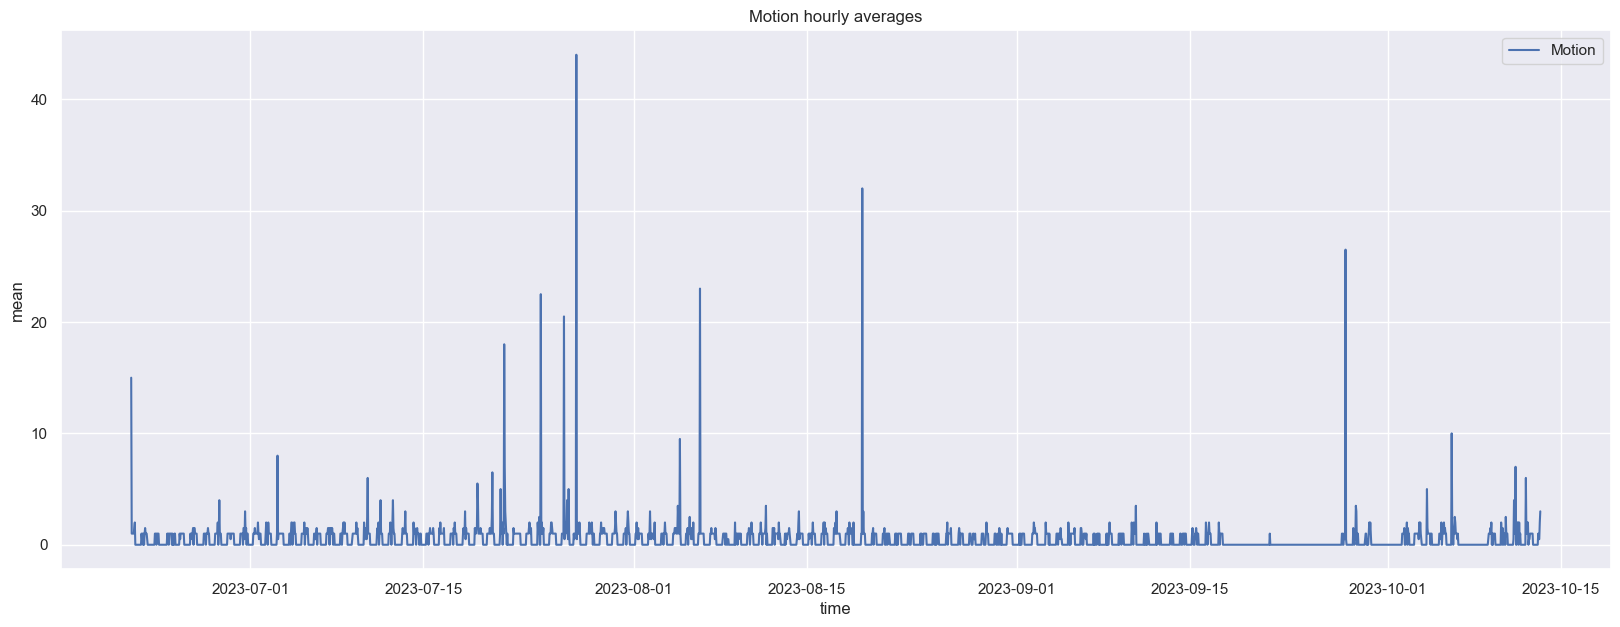

In [25]:
sns.set_theme(style="darkgrid")
plt.figure (figsize = (20, 7))
ax = plt.subplot()

sns.lineplot(x="time", y="mean", data=df5[["mean"]].resample("1h").median(), label="Motion")

ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter("%Y-%m-%d")
)
ax.set_title("Motion hourly averages")
ax.legend()
plt.show()

/Users/oxana/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


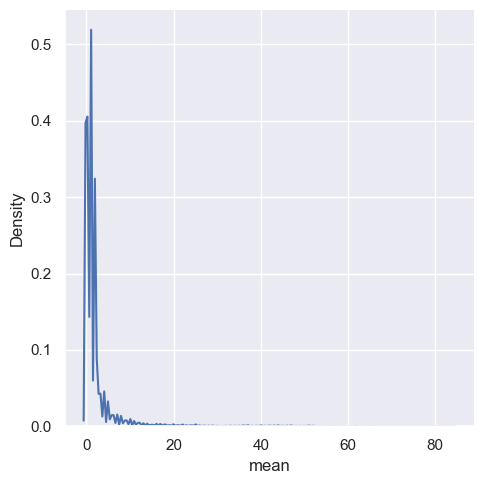

In [26]:
sns.displot(df5, x="mean",  kind="kde", bw_adjust=.25)

# Estimate amount of people based on motion and noise level (assuming they increase linearly)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
# read your data
df = pd.read_csv('ms-dessi-data/backup/data_all_3b25.csv')
df['time'] = pd.to_datetime(df['time'], format='mixed')
df.head()

,index,batteryVoltage_3b25,mean,time,contextMap_temperatureAlarmHysteresis_3b25,contextMap_temperatureHighAlarmLevel_3b25,contextMap_temperatureLowAlarmLevel_3b25,encodedData_port_3b25,frameCount_3b25,illuminance_3b25,...,settings_RhPer_3b25,settings_SendPer_3b25,settings_SoundPer_3b25,settings_SplPer_3b25,settings_TempPer_3b25,settings_VddPer_3b25,settings_Version_3b25,temperature_3b25,temperatureHighAlarm_3b25,temperatureLowAlarm_3b25
0,0,3.624,3.624,2023-09-21 13:25:45.731000+00:00,1.0,30.0,4.0,5,537,508.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.7,0.0,0.0
1,1,3.621,3.621,2023-09-21 13:15:45.901000+00:00,1.0,30.0,4.0,5,536,478.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.6,0.0,0.0
2,2,3.621,3.621,2023-09-21 04:15:47.589000+00:00,1.0,30.0,4.0,5,482,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.3,0.0,0.0
3,3,3.621,3.621,2023-09-21 04:05:47.778000+00:00,1.0,30.0,4.0,5,481,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.3,0.0,0.0
4,4,3.619,3.619,2023-09-21 03:25:47.876000+00:00,1.0,30.0,4.0,5,477,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.4,0.0,0.0


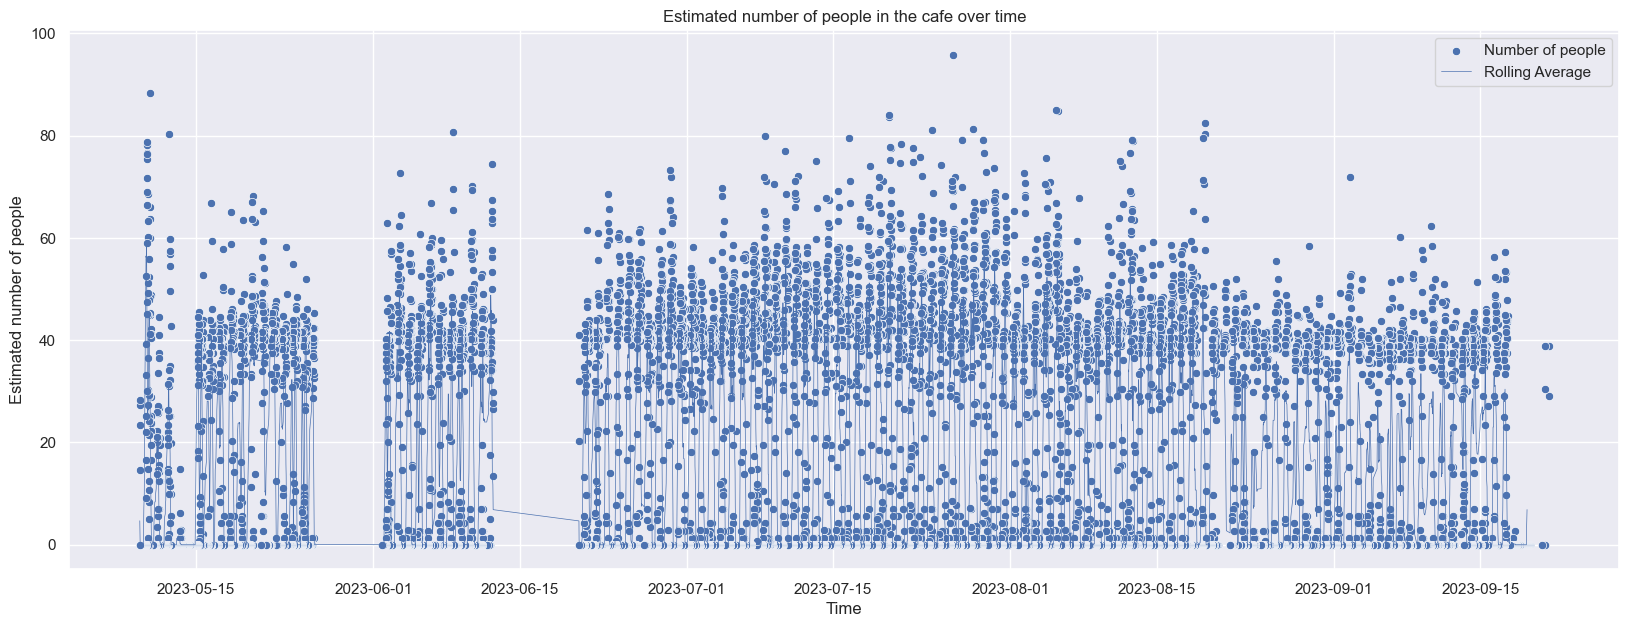

In [4]:
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.figure (figsize = (20, 7))
ax = plt.subplot()

# normalizing the motion column 
df["motion_3b25"] = (df["motion_3b25"] - df["motion_3b25"].min()) / (df["motion_3b25"].max() - df["motion_3b25"].min())

# normalizing the noise_level_average column
df["noiseLevelAverage"] = (df["noiseLevelAverage_3b25"] - df["noiseLevelAverage_3b25"].min()) / (df["noiseLevelAverage_3b25"].max() - df["noiseLevelAverage_3b25"].min())

# getting average of normalized columns to estimate people
df["estimated_people"] = (df["motion_3b25"] + df["noiseLevelAverage"]) / 2

# multiplying by a constant if required. For example if you know that max combined sensor readings correspond to 100 people
df["estimated_people"] = df["estimated_people"] * 100 

# Plotting the rolling average along with scatter plot
window_size = 20  # You can change it according to your needs.

# calculate moving average
df['rolling_avg'] = df['estimated_people'].rolling(window=window_size).mean()

# scatter plot of the estimated people over time
sns.scatterplot(x = pd.to_datetime(df['time']), y=df['estimated_people'], label='Number of people')

# plot of the rolling average
sns.lineplot(x=pd.to_datetime(df['time']), y=df['rolling_avg'], label='Rolling Average', linewidth=0.5)

plt.title("Estimated number of people in the cafe over time")
plt.xlabel('Time')
plt.ylabel('Estimated number of people')
plt.legend()

plt.show()

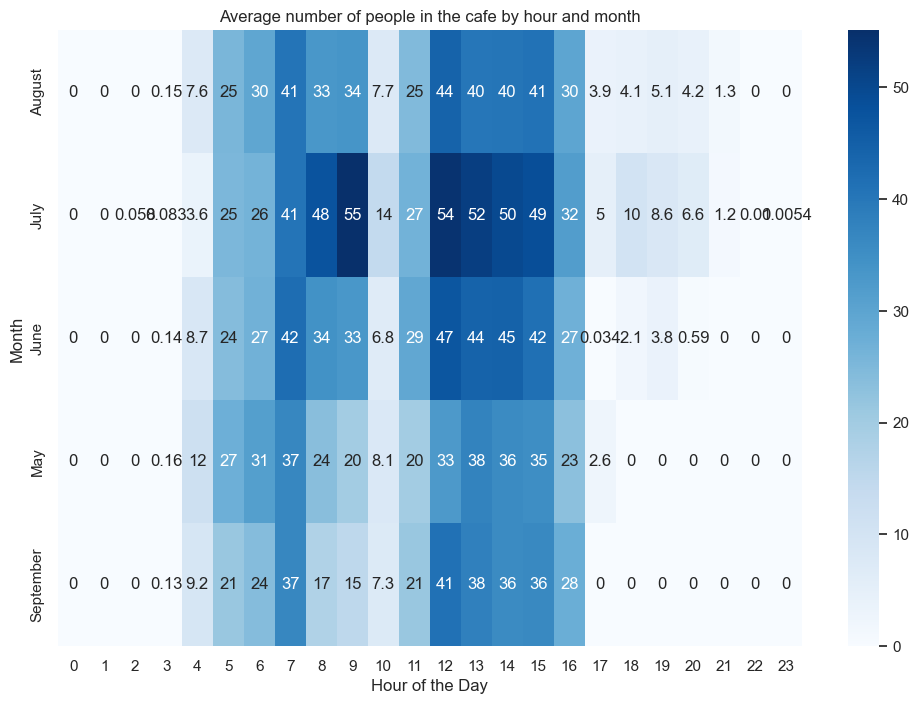

In [5]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['month'] = pd.to_datetime(df['time']).dt.month_name()
grouped = df.groupby(['month', 'hour'])['estimated_people'].mean().reset_index()

# reshape data for heatmap
heatmap_data = grouped.pivot(index='month', columns='hour', values='estimated_people')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True)
plt.title('Average number of people in the cafe by hour and month')
plt.xlabel('Hour of the Day')
plt.ylabel('Month')
plt.show()

In [6]:
df.head()

,index,batteryVoltage_3b25,mean,time,contextMap_temperatureAlarmHysteresis_3b25,contextMap_temperatureHighAlarmLevel_3b25,contextMap_temperatureLowAlarmLevel_3b25,encodedData_port_3b25,frameCount_3b25,illuminance_3b25,...,settings_VddPer_3b25,settings_Version_3b25,temperature_3b25,temperatureHighAlarm_3b25,temperatureLowAlarm_3b25,noiseLevelAverage,estimated_people,rolling_avg,hour,month
0,0,3.624,3.624,2023-09-21 13:25:45.731000+00:00,1.0,30.0,4.0,5,537,508.0,...,NaN,NaN,19.7,0.0,0.0,0.777778,38.888889,NaN,13,September
1,1,3.621,3.621,2023-09-21 13:15:45.901000+00:00,1.0,30.0,4.0,5,536,478.0,...,NaN,NaN,19.6,0.0,0.0,0.583333,29.166667,NaN,13,September
2,2,3.621,3.621,2023-09-21 04:15:47.589000+00:00,1.0,30.0,4.0,5,482,3.0,...,NaN,NaN,18.3,0.0,0.0,0.777778,38.888889,NaN,4,September
3,3,3.621,3.621,2023-09-21 04:05:47.778000+00:00,1.0,30.0,4.0,5,481,3.0,...,NaN,NaN,18.3,0.0,0.0,0.611111,30.555556,NaN,4,September
4,4,3.619,3.619,2023-09-21 03:25:47.876000+00:00,1.0,30.0,4.0,5,477,3.0,...,NaN,NaN,18.4,0.0,0.0,0.000000,0.000000,NaN,3,September


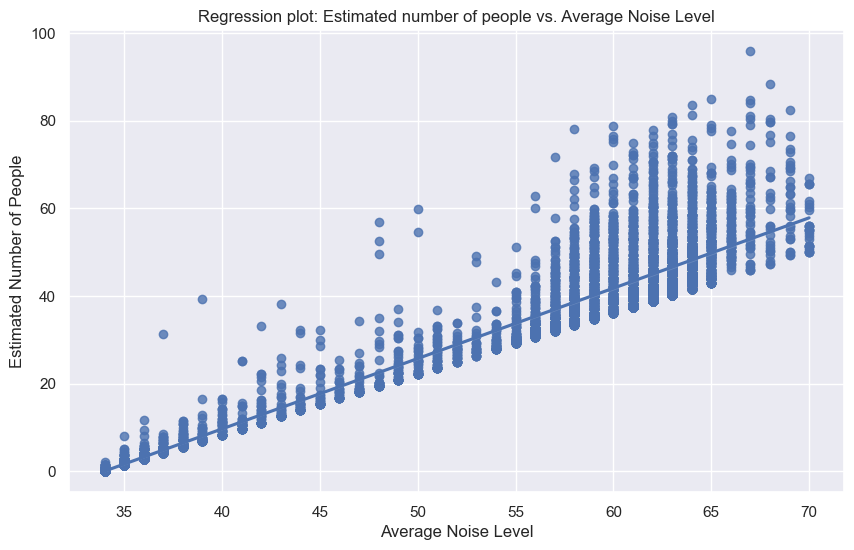

In [8]:
df_inside = df
df_outside = pd.read_csv('ms-dessi-data/backup/data_all_48b3.csv')
df_outside['time'] = pd.to_datetime(df['time'], format='mixed')
df_all = pd.merge(df_inside, df_outside, on="time", how="outer")

df_all.columns
df_all.to_csv('ms-dessi-data/inside_outside_combined.csv')

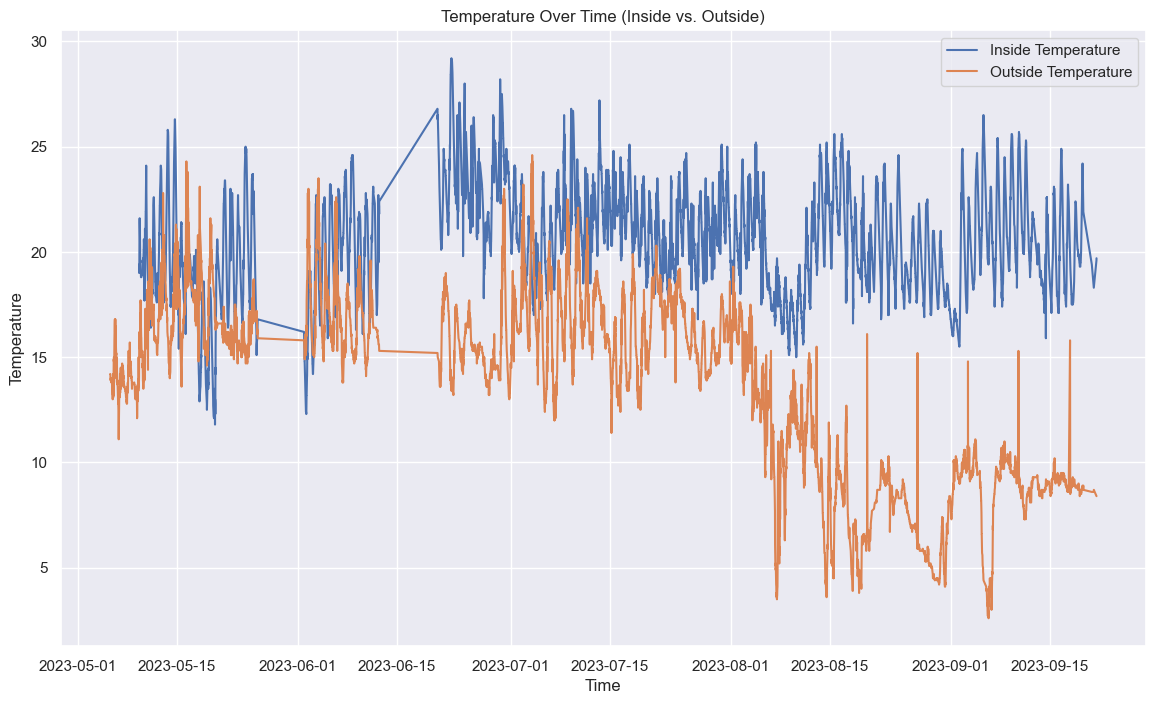

In [66]:
plt.figure(figsize=(14, 8))
sns.lineplot(x=df_all['time'], y=df_all['temperature_3b25'], label='Inside Temperature')
sns.lineplot(x=df_all['time'], y=df_all['temperature_48b3'], label='Outside Temperature')
plt.title('Temperature Over Time (Inside vs. Outside)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

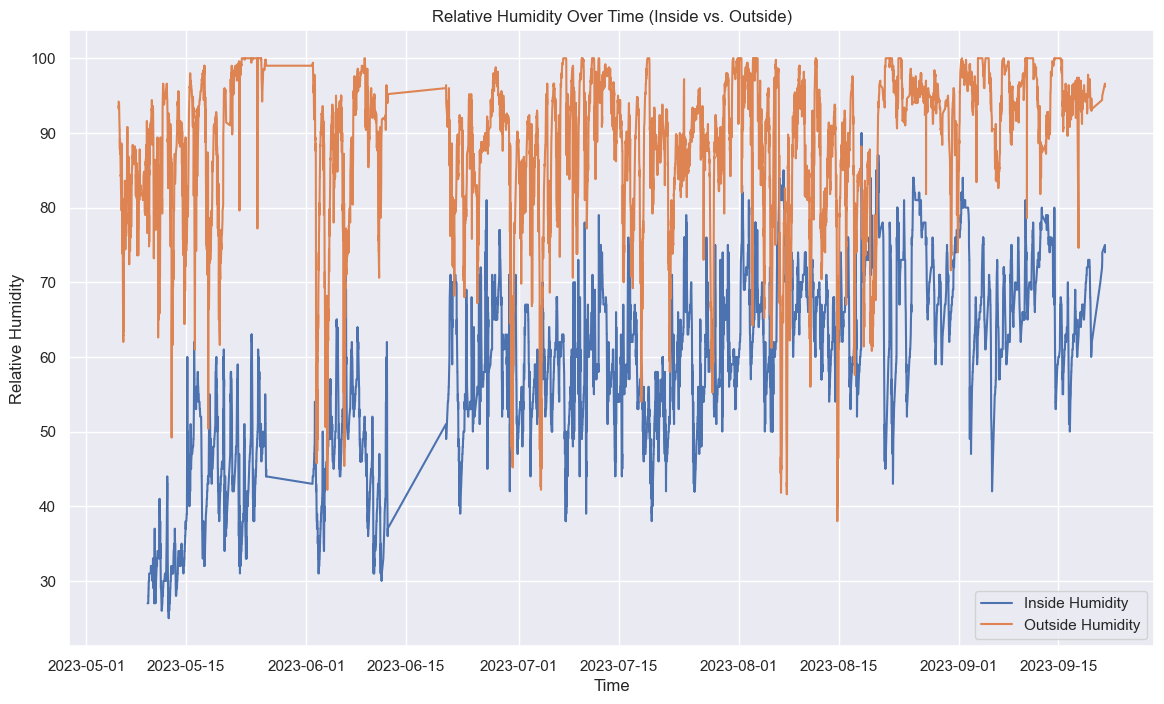

In [69]:
plt.figure(figsize=(14, 8))
sns.lineplot(x=df_all['time'], y=df_all['relativeHumidity_3b25'], label='Inside Humidity')
sns.lineplot(x=df_all['time'], y=df_all['relativeHumidity_48b3'], label='Outside Humidity')
plt.title('Relative Humidity Over Time (Inside vs. Outside)')
plt.xlabel('Time')
plt.ylabel('Relative Humidity')
plt.legend()
plt.show()